# Summary:
This notebook will cover the functions and steps used in the final webapp including both **BioBERT** and **LDA** methods. 

# Table of contents
* [1. BioBERT](#Part1_link)
<br >&nbsp;&nbsp;&nbsp;[1.1 Step1 -- obtain a ranked list of abstracts (cosine similarity scores)](#Part1.1_link)
<br >&nbsp;&nbsp;&nbsp;[1.2 Step2 -- Filter the abstract list according to gene mutation information](#Part1.2_link)
<br >&nbsp;&nbsp;&nbsp;[1.3 Step3 -- Filter the abstract list according to clinical trial information and match to oncologists](#Part1.3_link)
* [2. Latent Dirichlet Allocation (LDA)](#Part2_link)
<br >&nbsp;&nbsp;&nbsp;[2.1 Step1 -- obtain a ranked list of abstracts (cosine similarity scores)](#Part2.1_link)
<br >&nbsp;&nbsp;&nbsp;[2.2 Step2 -- Filter the abstract list according to gene mutation information](#Part2.2_link)
<br >&nbsp;&nbsp;&nbsp;[2.3 Step3 -- Filter the abstract list according to clinical trial information and match to oncologists](#Part2.3_link)
* [3. Visualize recommendation results from BioBERT using TSNE plot](#Part3_link)

In [26]:
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from ast import literal_eval
from transformers import BertTokenizer
from transformers import BertModel
import torch

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [27]:
base_dir='/Volumes/Yuchen_Drive/Insight/OncoMatch'

<a id='Part1_link'></a>
# 1. BioBERT

In [71]:
class Oncomatch_model():
    def __init__(self,cancer_type):
        self.base_dir='/Volumes/Yuchen_Drive/Insight/OncoMatch'
        self.cancer_type=cancer_type
        self.prefix="_".join(i.lower() for i in cancer_type.split())
        self.bert_df=pd.read_csv(os.path.join(self.base_dir,'bert_data/{}_abstract_bert_df.csv'.format(self.prefix)),index_col='pmid')
        self.model=BertModel.from_pretrained(os.path.join(self.base_dir, 'bert/biobert_v1.1_pubmed'))
        self.tokenizer = BertTokenizer.from_pretrained(os.path.join(self.base_dir, 'bert/biobert_v1.1_pubmed'), do_lower_case=True)
        
        self.onco_df=pd.read_csv(os.path.join(self.base_dir, "data/Oncologist_info_clinicaltrial_1470.csv"))
        self.onco_df.index=self.onco_df.name
        self.cancerclinical2doctor_dict_df=pd.read_csv(os.path.join(self.base_dir, 'data/cancerclinical2doctor_dict_df.csv'),converters={"doctor":literal_eval},index_col='cancer_type')
        self.doctor2clinical_dict2_df=pd.read_csv(os.path.join(self.base_dir, 'data/doctor2clinical_dict2_df.csv'),index_col='name')
        self.pmid2doctor_dict_df=pd.read_csv(os.path.join(self.base_dir, 'data/pmid2doctor_dict_df.csv'),converters={"doctor":literal_eval},index_col='pmid')
        
    def prepare_input_seq(self, input_seq, tokenizer, max_len):
        # here prepare the input sequence for the Bert model
        tokens0 = tokenizer.tokenize(input_seq)
        for j,t in enumerate(tokens0):
            if t in [".","?","!"]:
                tokens0[j] = t+" [SEP]"
        tokens = []
        for t in tokens0:
            tokens+=t.split()
        if tokens[-1]!='[SEP]':
            tokens = ['[CLS]'] + tokens + ['[SEP]']
        else:
            tokens = ['[CLS]'] + tokens

        if len(tokens)>max_len:
            padded_tokens = tokens[:max_len]
        else:
            padded_tokens = tokens

        indexed_tokens = tokenizer.convert_tokens_to_ids(padded_tokens)
        tokens_tensor = torch.tensor([indexed_tokens])

        return tokens_tensor
    
    def embed_sents(self, sents,model,max_len):
        # LM is the language model to be loaded separately.
        id2sent = {j:sent for j,sent in enumerate(sents)}
        emb_mat = np.zeros([len(id2sent),768])
        for j,sent in enumerate(sents):
            input_seq = sent
            tokens_tensor = self.prepare_input_seq(input_seq,self.tokenizer,max_len)
            val, hidden = model(tokens_tensor)
            val = torch.squeeze(val).mean(axis=0).reshape(1,-1)
            emb_mat[j,:] = val.detach().numpy()
        
        return emb_mat

    def get_embedding_vector(self, text):       
        text_bert = self.embed_sents([text], self.model,max_len=128)
        return text_bert

    def compute_similarity(self, embedding_matrix, text_vector):
        return cosine_similarity(X=embedding_matrix,Y=text_vector,dense_output=False)

    def get_similarity_scores(self, text):
        text_bert=self.get_embedding_vector(text)        
        text_bert_sim=self.compute_similarity(self.bert_df,text_bert)
        similarity_df=pd.DataFrame({'pmid':self.bert_df.index, 'bert_similarity':text_bert_sim.squeeze()}).sort_values(by=['bert_similarity'],ascending=False).reset_index().drop(['index'],axis=1)
        return similarity_df

    def get_onco_info(self, pmid_list,clinical_trial):
        """
        Input: cancer_type and a list of pmid
        Output: DataFrame containing information for oncologists that publish the articles
        """
        onco2pmid=defaultdict(list)
        onco2rank=defaultdict(list)
        for i,pmid in enumerate(pmid_list):
            for doctor in self.pmid2doctor_dict_df.loc[pmid,'doctor']:
                onco2pmid[doctor].append(pmid)
                onco2rank[doctor].append(i)
        temp_df = self.onco_df.loc[np.array(list(onco2pmid.keys()))]
        temp_df['query_pmid'] = temp_df.name.apply(lambda x:onco2pmid[x])
        temp_df['query_pmid_num'] = temp_df.name.apply(lambda x:len(onco2pmid[x]))
        temp_df['pmid_rank'] = temp_df.name.apply(lambda x:onco2rank[x])
        temp_df['pmid_rank_10th_percentile'] = temp_df.pmid_rank.apply(lambda x: sum(np.array(x)<=int(np.ceil(temp_df.shape[0]/10))))
        temp_df['clinical_trial_num2']='NA'

        if clinical_trial and self.cancer_type in self.cancerclinical2doctor_dict_df.index:
            doctor_clin = np.intersect1d(np.array(self.cancerclinical2doctor_dict_df.loc[self.cancer_type,'doctor']), temp_df.name.values)
            temp_df = temp_df.loc[np.array(doctor_clin)].sort_values(by=['pmid_rank_10th_percentile'],ascending=False)
            temp_df['clinical_trial_num2']=temp_df.name.apply(lambda x: int(self.doctor2clinical_dict2_df.loc[x, self.cancer_type]))

        return temp_df

    def get_clinical_data(self, onco_name):
        cancer_prefix="_".join(i.lower() for i in self.cancer_type.split())
        temp_df = pd.read_csv(os.path.join(self.base_dir, 'clinical_trial/{}_clinical_trial_info.csv'.format(cancer_prefix)))
        temp_df_onco=temp_df.query('name=="{}"'.format(onco_name))
        return temp_df_onco

In [72]:
class Get_info():
    def __init__(self):
        self.base_dir='/Volumes/Yuchen_Drive/Insight/OncoMatch'
        
    def gene_to_pmid(self,gene,data):
        pmid_array = data.query('HGNC=="{}"'.format(gene)).pmid.unique()
        return pmid_array

<a id='Part1.1_link'></a>
## 1.1 Step1 -- obtain a ranked list of abstracts (cosine similarity scores)

In [73]:
## Choose a cancer type
cancer_type='Melanoma'

In [74]:
## Free-form text input from Dr. Jedd D. Wolchok biography
mskcc_text_df=pd.read_csv(os.path.join(base_dir, 'data/mskcc_text_dict_df.csv'),index_col='name')
onco_name = 'Jedd D. Wolchok'
original_text=mskcc_text_df.loc[onco_name,'text']

In [75]:
## Obtain a ranked list of abstracts
onco=Oncomatch_model(cancer_type)
similarity_df=onco.get_similarity_scores(original_text)

In [76]:
similarity_df.head()

,pmid,bert_similarity
0,28835114,0.969421
1,23438382,0.969339
2,21900389,0.967783
3,23806499,0.967571
4,23460532,0.966737


Text(0.5, 0, 'bert_similarity')

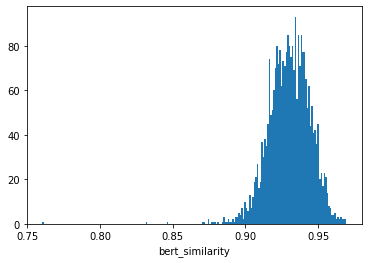

In [77]:
plt.hist(similarity_df.bert_similarity,bins=200)
plt.xlabel('bert_similarity')

<a id='Part1.2_link'></a>
## 1.2 Step2 -- Filter the abstract list according to gene mutation information

In [78]:
## Gene filtering
gene_name = 'NA'
if gene_name != 'NA':
    pmid_gene=Get_info().gene_to_pmid(gene_name, gene_df)
    pmid_list=[]
    for i in similarity_df.pmid:
        if i in pmid_gene:
            pmid_list.append(i)
else:
    pmid_list=list(similarity_df.pmid)   ## 865

<a id='Part1.3_link'></a>
## 1.3 Step3 -- Filter the abstract list according to clinical trial information and match to oncologists

### oncologists are ranked based on the number of abstracts in the top10 percentile of the cosine similarity scores

In [79]:
## clinical trial filtering and get oncologist info
clinical_trial = True
test_df = onco.get_onco_info(pmid_list,clinical_trial)   ## (95, 16)

In [80]:
test_df.head()

,name,degree,phone,center_name2,address,city_state,speciality,certificate,center_name,article_num,clinical_trial_num,query_pmid,query_pmid_num,pmid_rank,pmid_rank_10th_percentile,clinical_trial_num2
name,,,,,,,,,,,,,,,,
Jedd D. Wolchok,Jedd D. Wolchok,"MD, PhD, FASCO",(646) 888-2395,Memorial Sloan Kettering Cancer Center,1275 York AveBox 340,"New York, NY 10021, US","['Melanoma', 'Clinical Trials/Biostatistics/Ep...","['Hematology', 'Medical Oncology']",Memorial Sloan-Kettering Cancer Center,279,7,"[23438382, 23460532, 24188664, 24880949, 23933...",202,"[1, 4, 5, 7, 9, 16, 18, 20, 23, 30, 36, 41, 72...",12,6
F. Stephen Hodi,F. Stephen Hodi,MD,Search for Phone Number,Dana-Farber Cancer Institute,44 Binney St,"Boston, MA 02115, US","['Melanoma', 'Immunology/Immunobiology/Vaccines']","['Internal Medicine', 'Medical Oncology']",Dana-Farber/Harvard Cancer Center,225,14,"[23772560, 23709751, 23774827, 22168571, 24089...",160,"[16, 17, 27, 41, 48, 59, 71, 73, 77, 94, 102, ...",5,14
Keith Flaherty,Keith Flaherty,MD,(617) 726-1941,Massachusetts General Hospital,55 Fruit StYawkey 9E,"Boston, MA 02114, US","['Melanoma', 'Clinical Trials/Biostatistics/Ep...","['Hematology', 'Medical Oncology']",Massachusetts General Hospital,299,7,"[25931451, 22142824, 22217739, 21606968, 24089...",213,"[12, 14, 15, 19, 25, 53, 70, 80, 104, 111, 113...",5,5
Ahmad A. Tarhini,Ahmad A. Tarhini,"MD, PhD",813-745-8581,H. Lee Moffitt Cancer Center and Research Inst...,H. Lee Moffitt Cancer Center and Research Inst...,"Tampa, Florida 33612, US","['Lung Cancer', 'Melanoma', 'Biologic Therapy'...",['Medical Oncology'],Moffitt Cancer Center,75,16,"[23444951, 28434398, 23731854, 26177647, 23090...",61,"[24, 32, 34, 47, 57, 86, 89, 93, 95, 125, 141,...",4,10
Thomas Gajewski,Thomas Gajewski,"MD, PhD",Search for Phone Number,University of Chicago,5841 S Maryland AveMC2115,"Chicago, IL 60637-1463, US","['Melanoma', 'Biologic Therapy', 'Clinical Tri...","['Hematology', 'Medical Oncology']",The University of Chicago Comprehensive Cancer...,133,11,"[23731854, 22168571, 26619946, 30031393, 27846...",82,"[34, 41, 45, 52, 115, 153, 162, 164, 190, 198,...",3,10


<a id='Part2_link'></a>
# 2. Latent Dirichlet Allocation (LDA)

In [45]:
import gensim
from nltk.stem import WordNetLemmatizer

In [46]:
class Oncomatch_model():
    def __init__(self,cancer_type):
        self.base_dir='/Volumes/Yuchen_Drive/Insight/OncoMatch'
        self.cancer_type=cancer_type
        self.prefix="_".join(i.lower() for i in cancer_type.split())
        self.bow_dict=gensim.corpora.Dictionary.load(os.path.join(self.base_dir,'models_lda/{}_abstract_bow_dict.dict'.format(self.prefix)))
        self.tfidf=gensim.models.TfidfModel.load(os.path.join(self.base_dir,'models_lda/{}_abstract_tfidf.tfidf'.format(self.prefix)))
        self.lda_model=gensim.models.LdaMulticore.load(os.path.join(self.base_dir,'models_lda/{}_abstract_lda.lda'.format(self.prefix)))
        self.lda_df=pd.read_csv(os.path.join(self.base_dir, "models_lda/{}_abstract_ldavector_df.csv".format(self.prefix)), index_col='pmid').drop(['pred'],axis=1)
        self.stop_words=pickle.load(open(os.path.join(self.base_dir, "data/stop_words_lda.set"),"rb"))
        
        self.onco_df=pd.read_csv(os.path.join(self.base_dir, "data/Oncologist_info_clinicaltrial_1470.csv"))
        self.onco_df.index=self.onco_df.name
        self.cancerclinical2doctor_dict_df=pd.read_csv(os.path.join(self.base_dir, 'data/cancerclinical2doctor_dict_df.csv'),converters={"doctor":literal_eval},index_col='cancer_type')
        self.doctor2clinical_dict2_df=pd.read_csv(os.path.join(self.base_dir, 'data/doctor2clinical_dict2_df.csv'),index_col='name')
        self.pmid2doctor_dict_df=pd.read_csv(os.path.join(self.base_dir, 'data/pmid2doctor_dict_df.csv'),converters={"doctor":literal_eval},index_col='pmid')
        
    def preprocess(self, text):
        result = []
        for token in gensim.utils.simple_preprocess(text):
            temp=WordNetLemmatizer().lemmatize(token).lower()
            if len(temp)>1 and temp not in self.stop_words:
                result.append(temp)
        return result

    def get_embedding_vector(self, text):
        text_corpus=[self.bow_dict.doc2bow(text)]
        text_tfidf=self.tfidf[text_corpus]
        text_lda=self.lda_model[text_tfidf]
        text_lda = gensim.matutils.corpus2csc(text_lda)
        text_lda = text_lda.T.toarray()
        return text_lda

    def compute_similarity(self, embedding_matrix, text_vector):
        return cosine_similarity(X=embedding_matrix,Y=text_vector,dense_output=False)

    def get_similarity_scores(self, text):
        text_preprocess=self.preprocess(text)
        text_lda=self.get_embedding_vector(text_preprocess)
        text_lda_sim=self.compute_similarity(self.lda_df,text_lda)
        similarity_df=pd.DataFrame({'pmid':self.lda_df.index, 'lda_similarity':text_lda_sim.squeeze()}).sort_values(by=['lda_similarity'],ascending=False).reset_index().drop(['index'],axis=1)
        return similarity_df
    
    def get_onco_info(self, pmid_list,clinical_trial):
        """
        Input: cancer_type and a list of pmid
        Output: DataFrame containing information for oncologists that publish the articles
        """
        onco2pmid=defaultdict(list)
        onco2rank=defaultdict(list)
        for i,pmid in enumerate(pmid_list):
            for doctor in self.pmid2doctor_dict_df.loc[pmid,'doctor']:
                onco2pmid[doctor].append(pmid)
                onco2rank[doctor].append(i)
        temp_df = self.onco_df.loc[np.array(list(onco2pmid.keys()))]
        temp_df['query_pmid'] = temp_df.name.apply(lambda x:onco2pmid[x])
        temp_df['query_pmid_num'] = temp_df.name.apply(lambda x:len(onco2pmid[x]))
        temp_df['pmid_rank'] = temp_df.name.apply(lambda x:onco2rank[x])
        temp_df['pmid_rank_10th_percentile'] = temp_df.pmid_rank.apply(lambda x: sum(np.array(x)<=int(np.ceil(temp_df.shape[0]/10))))
    
        if clinical_trial and self.cancer_type in self.cancerclinical2doctor_dict_df.index:
            doctor_clin = np.intersect1d(np.array(self.cancerclinical2doctor_dict_df.loc[self.cancer_type,'doctor']), temp_df.name.values)
            temp_df = temp_df.loc[np.array(doctor_clin)].sort_values(by=['pmid_rank_10th_percentile'],ascending=False)
            temp_df['clinical_trial_num2']=temp_df.name.apply(lambda x: int(self.doctor2clinical_dict2_df.loc[x, self.cancer_type]))
    
        return temp_df

    def get_clinical_data(self, onco_name):
        cancer_prefix="_".join(i.lower() for i in self.cancer_type.split())
        temp_df = pd.read_csv(os.path.join(self.base_dir, 'clinical_trial/{}_clinical_trial_info.csv'.format(cancer_prefix)))
        temp_df_onco=temp_df.query('name=="{}"'.format(onco_name))
        return temp_df_onco

In [47]:
class Get_info():
    def __init__(self):
        self.base_dir='/Volumes/Yuchen_Drive/Insight/OncoMatch'
        
    def gene_to_pmid(self,gene,data):
        pmid_array = data.query('HGNC=="{}"'.format(gene)).pmid.unique()
        return pmid_array

<a id='Part2.1_link'></a>
## 2.1 Step1 -- obtain a ranked list of abstracts (cosine similarity scores)

In [48]:
## Choose a cancer type
cancer_type='Melanoma'

In [49]:
## Free-form text input from Dr. Jedd D. Wolchok biography
mskcc_text_df=pd.read_csv(os.path.join(base_dir, 'data/mskcc_text_dict_df.csv'),index_col='name')
onco_name = 'Jedd D. Wolchok'
original_text=mskcc_text_df.loc[onco_name,'text']

In [50]:
## Obtain a ranked list of abstracts
onco=Oncomatch_model(cancer_type)
similarity_df=onco.get_similarity_scores(original_text)

In [51]:
similarity_df.head()

,pmid,lda_similarity
0,23434733,0.995705
1,29749569,0.994658
2,15523088,0.994461
3,24720932,0.980880
4,26181286,0.975951


Text(0.5, 0, 'lda_similarity')

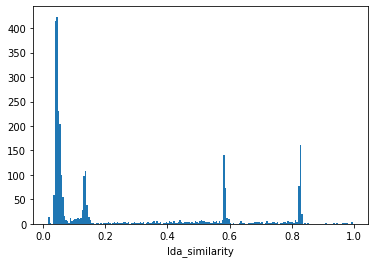

In [52]:
plt.hist(similarity_df.lda_similarity,bins=200)
plt.xlabel('lda_similarity')

<a id='Part2.2_link'></a>
## 2.2 Step2 -- Filter the abstract list according to gene mutation information

In [53]:
## Gene filtering
gene_name = 'NA'
if gene_name != 'NA':
    pmid_gene=Get_info().gene_to_pmid(gene_name, gene_df)
    pmid_list=[]
    for i in similarity_df.pmid:
        if i in pmid_gene:
            pmid_list.append(i)
else:
    pmid_list=list(similarity_df.pmid)   ## 865

<a id='Part2.3_link'></a>
## 2.3 Step3 -- Filter the abstract list according to clinical trial information and match to oncologists

### oncologists are ranked based on the number of abstracts in the top10 percentile of the cosine similarity scores

In [54]:
## clinical trial filtering and get oncologist info
clinical_trial = True
test_df = onco.get_onco_info(pmid_list,clinical_trial)   ## (95, 16)

In [55]:
test_df.head()

,name,degree,phone,center_name2,address,city_state,speciality,certificate,center_name,article_num,clinical_trial_num,query_pmid,query_pmid_num,pmid_rank,pmid_rank_10th_percentile,clinical_trial_num2
name,,,,,,,,,,,,,,,,
Jedd D. Wolchok,Jedd D. Wolchok,"MD, PhD, FASCO",(646) 888-2395,Memorial Sloan Kettering Cancer Center,1275 York AveBox 340,"New York, NY 10021, US","['Melanoma', 'Clinical Trials/Biostatistics/Ep...","['Hematology', 'Medical Oncology']",Memorial Sloan-Kettering Cancer Center,279,7,"[19558193, 26317466, 15800947, 28841387, 19103...",202,"[7, 8, 17, 26, 45, 53, 77, 78, 82, 84, 115, 12...",5,6
Patrick Hwu,Patrick Hwu,MD,Search for Phone Number,University of Texas MD Anderson Cancer Center,1515 Holcombe BlvdUnit 430,"Houston, TX 77030, US","['Melanoma', 'Immunology/Immunobiology/Vaccines']",['Medical Oncology'],The University of Texas MD Anderson Cancer Center,182,5,"[21166498, 24292706, 28754817, 21111964, 27678...",142,"[24, 35, 40, 47, 65, 67, 71, 105, 119, 139, 16...",4,5
Keith Flaherty,Keith Flaherty,MD,(617) 726-1941,Massachusetts General Hospital,55 Fruit StYawkey 9E,"Boston, MA 02114, US","['Melanoma', 'Clinical Trials/Biostatistics/Ep...","['Hematology', 'Medical Oncology']",Massachusetts General Hospital,299,7,"[31358999, 19659612, 26037941, 28728868, 25265...",213,"[15, 20, 48, 60, 72, 87, 101, 113, 126, 128, 1...",3,5
Craig L. Slingluff,Craig L. Slingluff,MD,(434) 924-1730,University of Virginia,PO Box 800709,"Charlottesville, VA 22908-0709, US","['Melanoma', 'Biologic Therapy', 'Clinical Res...",['General Surgery'],University of Virginia Cancer Center,111,25,"[22435430, 23406162, 14734458, 24047116, 20221...",93,"[21, 25, 44, 135, 374, 401, 432, 545, 554, 560...",3,21
Kevin Kim,Kevin Kim,MD,(203) 785-4747,Yale Cancer Center,PO Box 208042333 Cedar Street,"New Haven, CT 06520-8042, US","['Gastrointestinal Cancer', 'Liver Cancer', 'L...",['Interventional Radiology/Diagnostic Radiology'],Yale Cancer Center,115,18,"[24720932, 23800008, 25962795, 22668797, 25148...",92,"[3, 6, 49, 67, 71, 109, 133, 136, 139, 143, 14...",3,13


**Conclusion**
<br>Here the biography from a melanoma oncologist Dr. Jedd D. Wolchok is used as the free-form text input. Both BioBERT and LDA based models will rank Dr. Jedd D. Wolchok as the 'best' matched oncologist. However, in BioBERT model, there are more relevant abstracts published by Dr. Jedd D. Wolchok in the top 10 percentile compared to the LDA model.

<a id='Part3_link'></a>
# 3. Visualize recommendation results from BioBERT using TSNE plot

In [120]:
cancer2pmid_dict=pickle.load(open(os.path.join(base_dir, "data/cancer2pmid_dict.pkl"),"rb"))
doctor2pmid_1153_dict_df=pd.read_csv(os.path.join(base_dir, 'data/doctor2pmid_1153_dict_df.csv'),converters={'pmid':literal_eval})

In [81]:
abstract_embedded_df = pd.read_csv(os.path.join(base_dir, 'bert_data/abstract_embed_bert_maxlen128.csv'),index_col='pmid')


In [88]:
onco=Oncomatch_model(cancer_type)
text_embed=onco.get_embedding_vector(original_text)

In [96]:
text_embed_df=pd.DataFrame(text_embed)
text_embed_df.columns=abstract_embedded_df.columns

In [107]:
abstract_embedded_df2=pd.concat([abstract_embedded_df,text_embed_df]).rename(index={0:'query'})

In [113]:
from sklearn.manifold import TSNE
tsne = TSNE()
abstract_tsne2 = tsne.fit_transform(abstract_embedded_df2)
abstract_tsne2=pd.DataFrame({'tsne1':abstract_tsne2[:,0],'tsne2':abstract_tsne2[:,1], 'pmid':abstract_embedded_df2.index})

In [114]:
abstract_tsne2.to_csv(os.path.join(base_dir,'bert_data/Jedd_Wolchok_tsne'),index=True)

In [126]:
melanoma_pmid=cancer2pmid_dict['Melanoma']
onco_pmid=doctor2pmid_1153_dict_df[doctor2pmid_1153_dict_df.name==onco_name].pmid.values[0]

In [179]:
abstract_tsne2['melanoma'] = abstract_tsne2.pmid.apply(lambda x: 3 if x=='query' else (2 if (x in melanoma_pmid and x in onco_pmid) else (1 if x in melanoma_pmid else 0)))
abstract_tsne2['query'] = abstract_tsne2.pmid.apply(lambda x:True if x =='query' else False)

In [180]:
tmp1 = abstract_tsne2[abstract_tsne2.melanoma != 0]
tmp2 = abstract_tsne2[(abstract_tsne2.melanoma == 0)]
abstract_tsne3 = pd.concat([tmp2,tmp1])

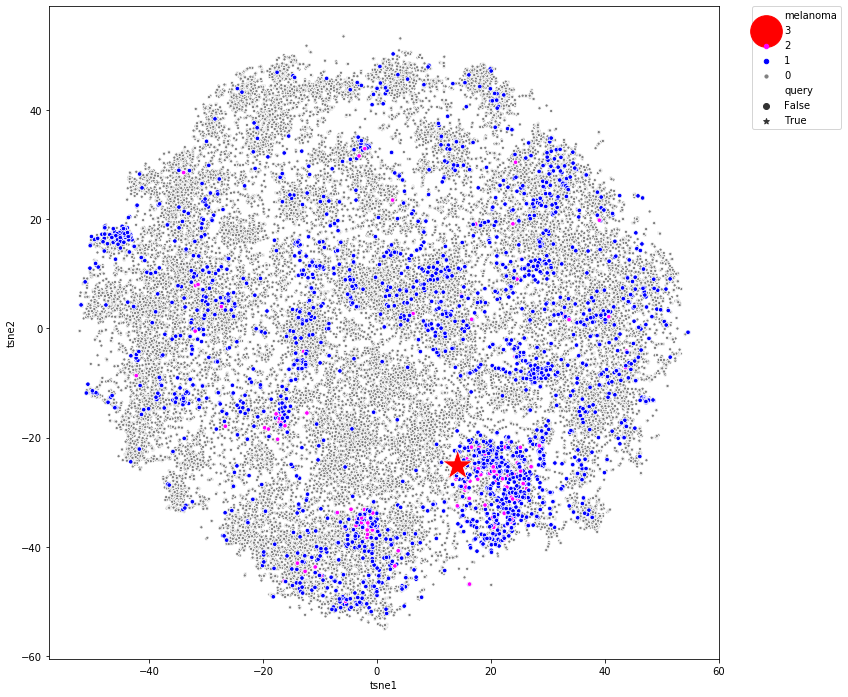

In [187]:
fig, ax = plt.subplots(figsize=(12, 12))
markers = {False: "o", True: "*"}
sns.scatterplot(x='tsne1',
                y='tsne2',
                data=abstract_tsne3, 
                hue = 'melanoma', 
                hue_order=[3,2,1,0], 
                palette=['red','magenta','blue','grey'], 
                ax=ax, 
                alpha=1,
                size='melanoma',
                size_order=[3,2,1,0],
                sizes=[1000,20,20,10],
                style='query',
                style_order=[False,True],
                markers=markers)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

The 'red' star represents the vector representation of Dr. Jedd D. Wolchok's biography. The magenta data points represent abstracts published by Dr. Jedd D. Wolchok in melanoma area. The blue data points represent all the abstracts in melanoma.